In [ ]:
!pip install -U tensorflow-addons

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
num_classes = 10
input_shape = (28, 28, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test  = tf.expand_dims(x_test, axis=3, name= None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test  = tf.repeat(x_test,3, axis=3, name=None)
# One-hot encoding 
y_train = tf.keras.utils.to_categorical(y_train)
y_test  = tf.keras.utils.to_categorical(y_test)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (60000, 28, 28, 3) - y_train shape: (60000, 10)
x_test shape: (10000, 28, 28, 3) - y_test shape: (10000, 10)


In [ ]:
learning_rate = 1e-4
weight_decay = 1e-6
batch_size = 32
num_epochs = 10
image_size = 224
patch_size = 1 # Size of the patches to be extracted from the input images
num_patches = (image_size // patch_size) **2
projection_dim = 128
num_heads = 12
transformer_units = [ 4*projection_dim,
                      projection_dim,
                     ] # Size of the tranformer layers

transformer_layers = 12

In [ ]:
data_augmentation = tf.keras.Sequential(
    [   layers.Resizing(image_size, image_size),
        layers.RandomRotation(10),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        layers.Rescaling(1./255),
        
    ],
    name="data_augmentation",
)

In [ ]:
def mlp(x, hidden_units, dropout_rate = 0.1):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation = tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
y = mlp(tf.zeros((1, 197, 768)),[768], 0.1)
y

<tf.Tensor: shape=(1, 197, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        
        patch_dims = patches.shape[-1]
        
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        
        return patches

image.shape = (28, 28, 3)
Image size: 224 X 224
Patch size: 1 X 1
Patches per image: 784
Elements per patch: 3


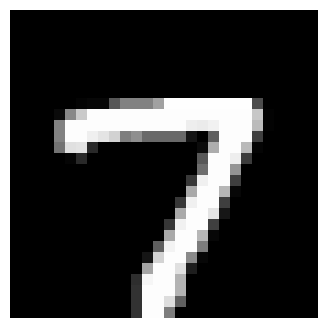

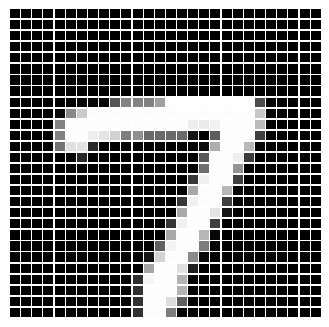

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
print(f"image.shape = {image.shape}")
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)( tf.convert_to_tensor([image]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches=196, projection_dim=768):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        w_init = tf.random_normal_initializer()
        class_token = w_init(shape=(1, projection_dim), dtype="float32")
        self.class_token = tf.Variable(initial_value=class_token, trainable=True)
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(input_dim=num_patches+1, output_dim=projection_dim)

    def call(self, patch):
        batch = tf.shape(patch)[0]
        # reshape the class token embedins
        class_token = tf.tile(self.class_token, multiples = [batch, 1])
        class_token = tf.reshape(class_token, (batch, 1, self.projection_dim))
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        patches_embed = tf.concat([patches_embed, class_token], 1)
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches+1, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded

In [ ]:
class PatchClassEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model = projection_dim, n_patches = num_patches, kernel_initializer='he_normal', **kwargs):
        super(PatchClassEmbedding, self).__init__(**kwargs)
        self.d_model = d_model
        self.n_tot_patches = n_patches + 1
        self.kernel_initializer = kernel_initializer
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.class_embed = self.add_weight(shape=(
            1, 1, self.d_model), initializer=self.kernel_initializer, name="class_token")  # extra learnable class
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=(self.n_tot_patches), output_dim=self.d_model
        )

    def get_config(self):
        config = {
            'd_model': self.d_model,
            'n_tot_patches': self.n_tot_patches,
            'kernel_initializer': self.kernel_initializer
        }

        base_config = super(PatchClassEmbedding, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
        positions = tf.range(start=0, limit=self.n_tot_patches, delta=1)
        x = tf.repeat(self.class_embed, tf.shape(inputs)[0], axis=0)
        x = tf.concat((x, inputs), axis=1)
        encoded = x + self.position_embedding(positions)
        return 

In [ ]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
print(resized_image.shape)
patches = Patches(patch_size)(resized_image)
print(patches.shape)
patches = tf.keras.layers.Dense(projection_dim)(patches)
print(patches.shape)
patch_encoder =  PatchEncoder(num_patches, projection_dim)
encoded = patch_encoder(patches)
encoded.shape


(1, 224, 224, 3)
(1, 50176, 3)
(1, 50176, 128)


TensorShape([1, 50177, 128])

In [ ]:
def resnet50_feature_extractor():
    #Preprocess the input image for xception feature extractor
    input = tf.keras.layers.Input(shape = (224,224,3))
    resnet50_feature_extractor = tf.keras.applications.resnet50.ResNet50(include_top = False, weights = "imagenet", input_shape = (224,224,3))
    resnet50_feature_extractor.summary()
    feature =  resnet50_feature_extractor(input)
    model = tf.keras.Sequential([input,
                                resnet50_feature_extractor])
    model.summary()
    return model

Resnet50_feature_extractor = resnet50_feature_extractor()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
def create_hybrid_vit_classifier():
    inputs = tf.keras.layers.Input(shape=input_shape)
    
     # Augment data.
    augmented = data_augmentation(inputs)

    #feature extractor
    features = Resnet50_feature_extractor(augmented)  
   
    feature_shape = features.shape
   
    # Create patches.
    patches = Patches(patch_size)(features)
   
    # Position Embedding + Extra learnable class embedding
    num_patches = (feature_shape[1]//patch_size)**2
    # Position Embedding + Extra learnable class embedding
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = tf.keras.layers.Dense(projection_dim, activation="tanh")(representation)
    # Add MLP. (No representation layers needed)
    ##features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    representation = tf.keras.layers.BatchNormalization()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)
    output = layers.Dense(num_classes,activation="softmax")(representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=output)
    model.summary()
    return model

In [ ]:
model = create_hybrid_vit_classifier()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 3)  0          ['input_6[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 7, 7, 2048)   23587712    ['data_augmentation[1][0]']      
                                                                                                  
 patches_2 (Patches)            (None, None, 2048)   0           ['sequential_1[0][0]']           
                                                                                              

In [ ]:
def train_model(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy")
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=5, mode="max")
    
    logger = tf.keras.callbacks.TensorBoard( 
        log_dir=f'logs/hybrid_ViTb16-224x224',
        histogram_freq=5,
        write_graph=True,
        write_images=True,
        write_steps_per_second=True,
        update_freq='epoch',
        profile_batch=0,
        embeddings_freq=0,
        embeddings_metadata=True)

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback,logger,reduce_lr],
    )

    model.load_weights(checkpoint_filepath)
    loss, accuracy = model.evaluate(x_test, y_test)    
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test loss : {loss}")
    print("Save Model and Weight to Disk")
    model.save("hybrid_ViTb16-224x224.tf")
    model.save_weights("hybrid_ViTb16-224x224_weights.h5")

    return history


vit_classifier = create_hybrid_vit_classifier()
history = train_model(vit_classifier)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 3)  0          ['input_7[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 7, 7, 2048)   23587712    ['data_augmentation[2][0]']      
                                                                                                  
 patches_3 (Patches)            (None, None, 2048)   0           ['sequential_1[1][0]']           
                                                                                            

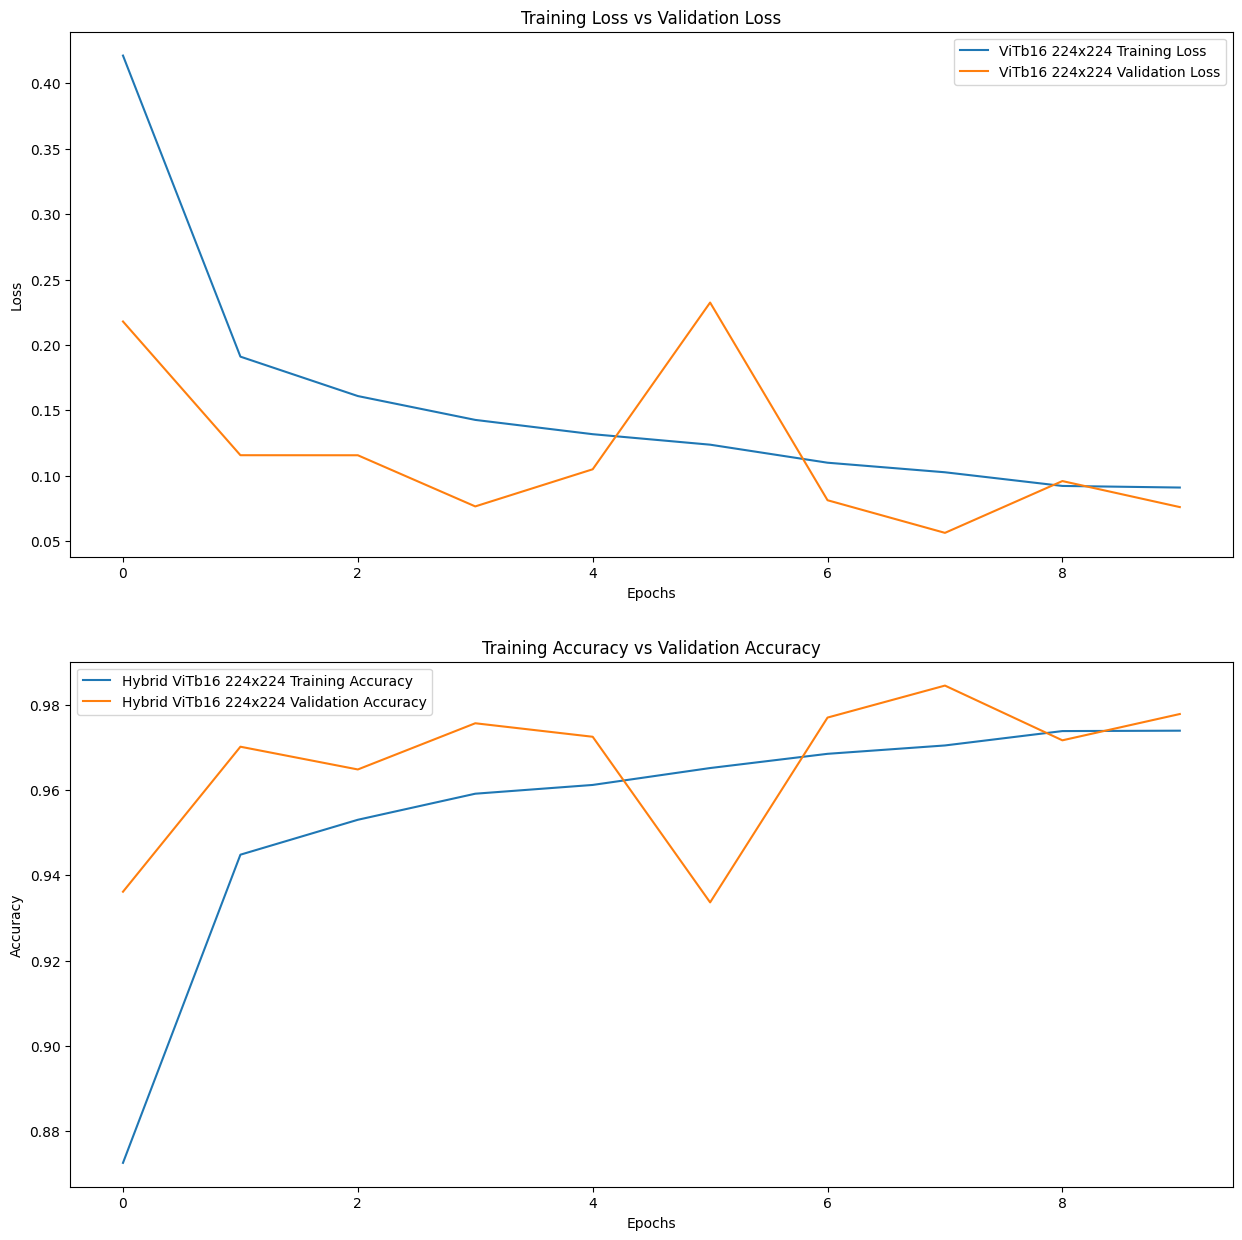

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])

axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['ViTb16 224x224 Training Loss', 'ViTb16 224x224 Validation Loss'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Hybrid ViTb16 224x224 Training Accuracy', 'Hybrid ViTb16 224x224 Validation Accuracy'])

In [ ]:
import itertools
from tensorflow.keras import layers, models,Input, Model
import numpy as np
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, auc, roc_curve

## Load the Trained Model
CNN_model = models.load_model("hybrid_ViTb16-224x224.tf")

## Make Prediction for the test datasets
predictions=CNN_model.predict(x_test)

## Convert from one-hot(2D) encoding to 1D
predictions=np.argmax(predictions, axis=1)
labels=np.argmax(y_test, axis=1)
confusion_matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions)
confusion_matrix_original = confusion_matrix
confusion_matrix = confusion_matrix.numpy()

def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return float(sum_of_precisions / rows)

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return float(sum_of_recalls / columns)

def F1(label,confusion_matrix):      
    F1=2*(precision(label,confusion_matrix)*(recall(label,confusion_matrix)))/(precision(label,confusion_matrix)+recall(label,confusion_matrix))
    return F1

print("label precision recall F1")
for label in range(10):
    print(f"{label:5d} {precision(label, confusion_matrix):9.3f} {recall(label, confusion_matrix):6.3f} {F1(label,confusion_matrix):6.3f}")

def F1_macro_average(confusion_matrix):
    rows,columns = confusion_matrix.shape
    sum_of_F1=0
    for label in range(rows):
        sum_of_F1+=F1(label,confusion_matrix)        
    return float(sum_of_F1/columns)

print("precision total:", precision_macro_average(confusion_matrix))

print("recall total:", recall_macro_average(confusion_matrix))

print("F1 total:", F1_macro_average(confusion_matrix))

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

cm_classes=['0','1','2','3','4','5','6','7','8','9']

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix of  Hybrid ViT 224x224 for MNIST Object Recognition',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm=confusion_matrix,classes=cm_classes,title="Confusion Matrix of Hybrid ViT 224x224 for MNIST Object Recognition",cmap=plt.cm.Blues)

import sklearn
from sklearn import metrics
predictions=CNN_model.predict(x_test)

predictions=CNN_model.predict(x_test)
##predictions_list=[]
##predictions_list=[[1 if predictions[j][i]>0.5 else 0 for i in range(10)] for j in range(10000)]
predictions=np.argmax(predictions, axis=1)
labels=np.argmax(y_test, axis=1)
report = sklearn.metrics.classification_report(labels, predictions, digits=3)
print(report)

# Compute ROC curve and ROC area for each class
### roc_curve and auc is only support for one-hot encoding 
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=cm_classes)
disp.plot()
plt.title("Confusion Matrix of Hybrid ViT 224x224 Model for MNIST Object Recognition")
plt.show()

from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
fpr = dict()
tpr = dict()
predictions=CNN_model.predict(x_test)
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i]
                                  , predictions[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(),predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

n_classes=10
lw=3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

ImportError: ignored